# Exploratory Data Analysis 

TASKS: 
- understand the relationships between historical weather observations and the river gauge levels
- explore the missing values
- lagged variables? 
- visualisations of all above



In [3]:
import os
os.chdir('..')

In [4]:


import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import datetime as dt 
import yaml
from src.data_collection import fetch_and_save_river_data, pull_noaa_weather_data, fetch_weather_data_over_years, load_credentials
from src.transform_data import extract_time_values_from_csv, check_missing_days_in_csv
from src.transform_data import remove_negative_river_levels
import os 
import sys

## Plan of attack 
- Initially, we analyse river gauge and weather data separately
- Further, start with a single csv for river data, perform EDA on this
- Key requirements: missing values visualised, percentages 
- Develop code to create an EDA.py script so these functions are easily accesible later in the project: break down into different classes : IE class River, class Weather 
- Can generalise the river EDA to all 30 stations
- Weather data is simpler, we currently have one Cornwall station from NOAA
- After look at the relationships between water levels and weather data



Chose station 1335 randomly, it's Helston Country Bridge

In [5]:
station_1335 = pd.read_csv('./data/river_data/station_1335_clean.csv')

In [6]:
station_1335

,time,value
0,2014-03-04 04:15:00,0.772
1,2014-03-04 04:30:00,0.771
2,2014-03-04 04:45:00,0.771
3,2014-03-04 05:00:00,0.770
4,2014-03-04 05:15:00,0.771
...,...,...
276563,2024-07-11 21:15:00,0.320
276564,2024-07-11 21:45:00,0.318
276565,2024-07-11 22:30:00,0.319
276566,2024-07-11 22:45:00,0.317


In [7]:
station_1335.isnull().sum() # No nulls, but there are gaps in the days


time     0
value    0
dtype: int64

In [8]:
station_1335['time'] = pd.to_datetime(station_1335['time']) # convert to datetime

In [9]:
station_1335.set_index('time', inplace=True)

In [10]:
station_1335

,value
time,
2014-03-04 04:15:00,0.772
2014-03-04 04:30:00,0.771
2014-03-04 04:45:00,0.771
2014-03-04 05:00:00,0.770
2014-03-04 05:15:00,0.771
...,...
2024-07-11 21:15:00,0.320
2024-07-11 21:45:00,0.318
2024-07-11 22:30:00,0.319


In [11]:
station_1335 = station_1335.asfreq('15min')

In [12]:
station_1335

,value
time,
2014-03-04 04:15:00,0.772
2014-03-04 04:30:00,0.771
2014-03-04 04:45:00,0.771
2014-03-04 05:00:00,0.770
2014-03-04 05:15:00,0.771
...,...
2024-07-11 22:45:00,0.317
2024-07-11 23:00:00,NaN
2024-07-11 23:15:00,NaN


In [13]:
# Calculate the percentage of missing values in the 'value' column
missing_percentage = (station_1335['value'].isnull().sum() / len(station_1335)) * 100
print(f"There are {missing_percentage:.2f}% missing measurements in 'value'.")


There are 23.84% missing measurements in 'value'.


In [14]:
station_1335['value'] = station_1335['value'].apply(lambda x: np.nan if x<0 else x) # clean 

In [15]:
station_1335.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 363151 entries, 2014-03-04 04:15:00 to 2024-07-11 23:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   value   276566 non-null  float64
dtypes: float64(1)
memory usage: 5.5 MB


In [16]:
station_1335.describe()

,value
count,276566.000000
mean,0.482554
std,0.256352
min,0.144000
25%,0.277000
50%,0.415000
75%,0.616000
max,2.044000


<Axes: title={'center': 'Distribution of River Gauge Levels'}, ylabel='Frequency'>

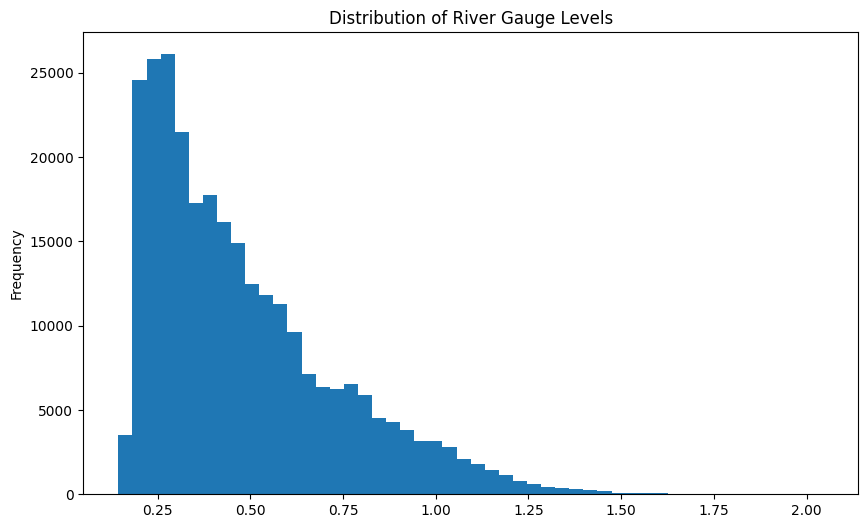

In [17]:
station_1335['value'].plot(kind='hist', bins=50, figsize=(10, 6), title='Distribution of River Gauge Levels')


In [129]:
reasonable_range = station_1335[(station_1335['value'] >= 0) & (station_1335['value'] <= 5)]
unreasonable_values = station_1335[~station_1335.index.isin(reasonable_range.index)]
print(f"Unreasonable values count: {len(unreasonable_values)}")


Unreasonable values count: 86585


In [130]:
station_1335.describe()

,value
count,276566.000000
mean,0.482554
std,0.256352
min,0.144000
25%,0.277000
50%,0.415000
75%,0.616000
max,2.044000


In [18]:
# Extracting time-related features

station_1335['year'] = station_1335.index.year
station_1335['month'] = station_1335.index.month
station_1335.reset_index(inplace=True)
station_1335['week'] = station_1335['time'].dt.isocalendar().week
station_1335['hour'] = station_1335['time'].dt.hour
station_1335['day'] = station_1335['time'].dt.dayofweek
station_1335['day_str'] = station_1335['time'].dt.strftime('%a')
station_1335['year_month'] = station_1335['time'].dt.strftime('%Y_%m')
station_1335.set_index('time', inplace=True)

In [133]:
station_1335.head(5)

,value,year,month,week,hour,day,day_str,year_month
time,,,,,,,,
2014-03-04 04:15:00,0.772,2014,3,10,4,1,Tue,2014_03
2014-03-04 04:30:00,0.771,2014,3,10,4,1,Tue,2014_03
2014-03-04 04:45:00,0.771,2014,3,10,4,1,Tue,2014_03
2014-03-04 05:00:00,0.770,2014,3,10,5,1,Tue,2014_03
2014-03-04 05:15:00,0.771,2014,3,10,5,1,Tue,2014_03


In [19]:
station_1335['value']  = station_1335['value'].interpolate(method='linear')

<Axes: title={'center': 'River Levels Over Time (Station 1335)'}, xlabel='time'>

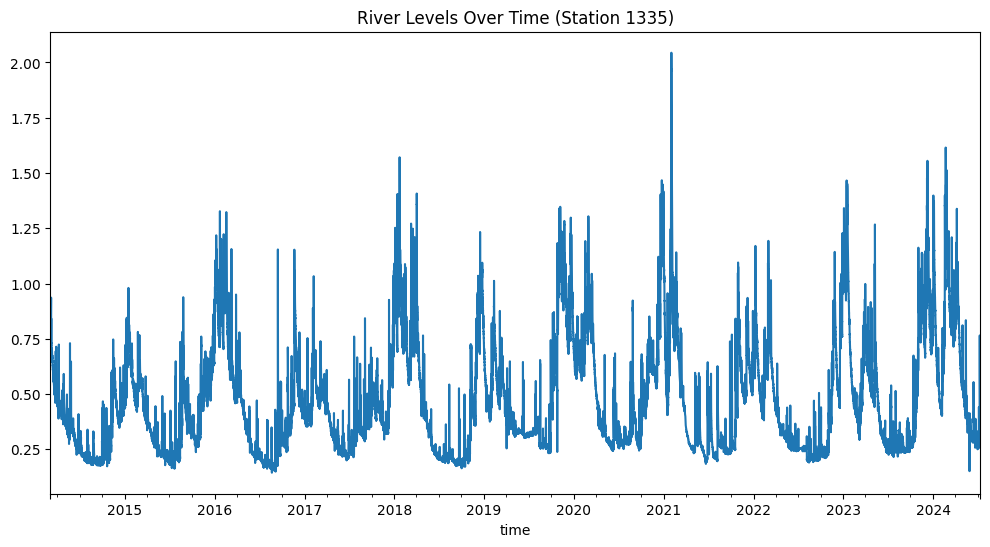

In [20]:
station_1335['value'].plot(figsize=(12, 6), title='River Levels Over Time (Station 1335)') # does work well with nulls, can interpolate (cell above)


In [41]:
station_1335 = station_1335.reset_index()

Seasonality: There are repeating patterns visible, with peaks and troughs occurring fairly regularly. This indicates some level of seasonality, likely related to rainfall or weather conditions.
Anomalies: There are a few periods with very high spikes in river levels, especially in 2019 and early 2020, which could be indicative of extreme weather events or floods.
Trend: It appears that the river levels have consistent fluctuations, without any obvious long-term upward or downward trend, though there might be slight variations over the years.
Range: The river levels seem to range mostly between 0.25 and 1.75 meters, which might indicate typical ranges for the station.

In [ ]:
# What about Boscastle flood in 2004? 

## Time Series Decomposition

### looks like additive decomposition makes sense, given no appearance of trend. 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting seed for reproducibility
np.random.seed(42)

# Assuming df is your DataFrame with 'value', 'month', and 'year' columns
df_plot = station_1335[['month', 'year', 'value']].groupby(['month', 'year']).mean().unstack('year')

# Renaming columns for clarity
df_plot.columns = df_plot.columns.droplevel()
df_plot.index.name = 'Month'


In [32]:
df_plot

year,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
Month,,,,,,,,,,,
1,NaN,0.647388,0.943407,0.401787,0.957259,0.489557,0.646517,0.768354,0.644624,1.017921,0.735106
2,NaN,0.511136,0.857077,0.569468,0.735145,0.640741,0.787218,0.932639,0.536969,0.468520,0.855934
3,0.594291,0.488122,0.577811,0.501534,0.744213,0.538541,0.764401,0.518432,0.653339,0.521908,0.888348
4,0.444418,0.331979,0.489982,0.369222,0.608819,0.399407,0.392273,0.282274,0.375345,0.627551,0.791409
5,0.357582,0.261693,0.326148,0.267675,0.367016,0.326638,0.306854,0.318759,0.292929,0.528605,0.432971
6,0.285600,0.223004,0.232717,0.244075,0.234413,0.324727,0.312701,0.249847,0.256210,0.289653,0.311972
7,0.225261,0.220794,0.192362,0.274726,0.207282,0.322116,0.286413,0.288104,0.253709,0.260682,0.342102
8,0.205326,0.375546,0.185338,0.350555,0.212848,0.300541,0.345898,0.271932,0.212111,0.263698,NaN
9,0.192685,0.396499,0.272775,0.416869,0.197410,0.288426,0.317549,0.252907,0.222436,0.259911,NaN


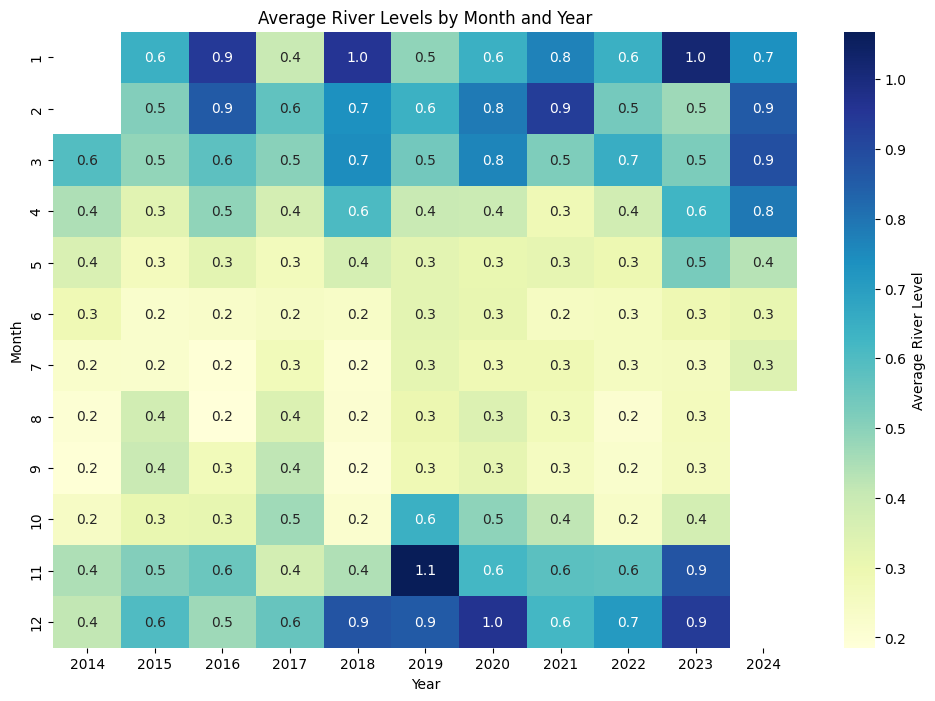

In [31]:
# Set up the figure size and plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_plot, cmap="YlGnBu", annot=True, fmt=".1f", cbar_kws={'label': 'Average River Level'})
plt.title('Average River Levels by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


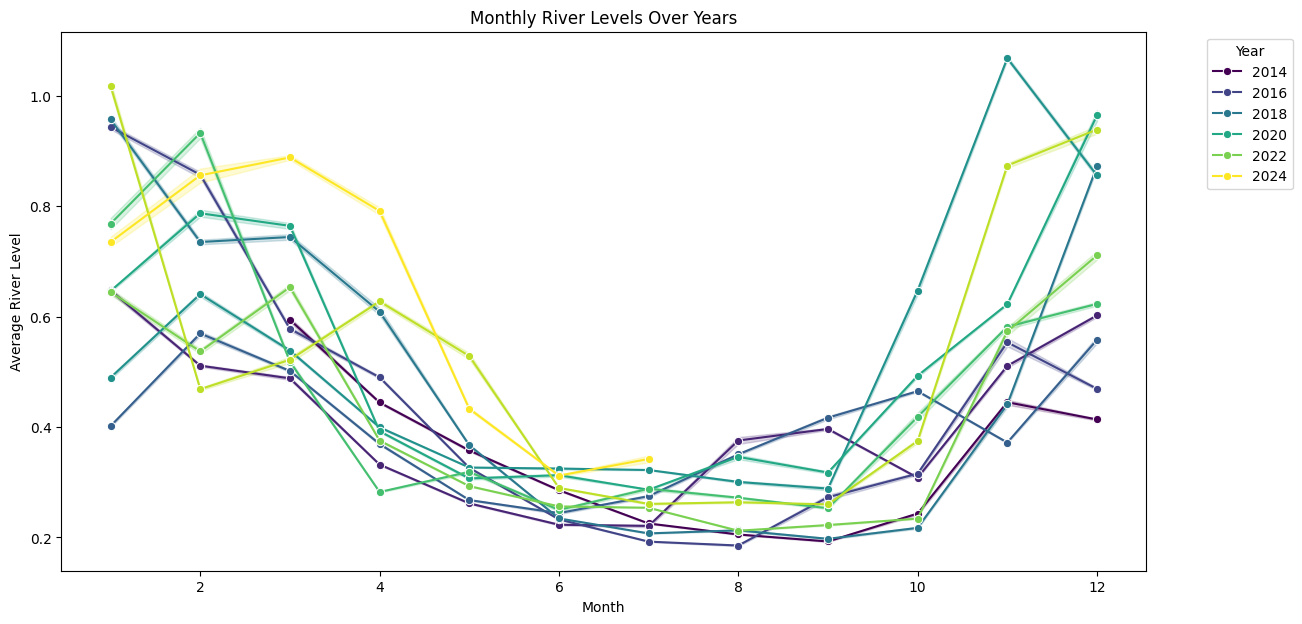

In [33]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=station_1335, x='month', y='value', hue='year', marker='o', palette="viridis")
plt.title('Monthly River Levels Over Years')
plt.xlabel('Month')
plt.ylabel('Average River Level')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


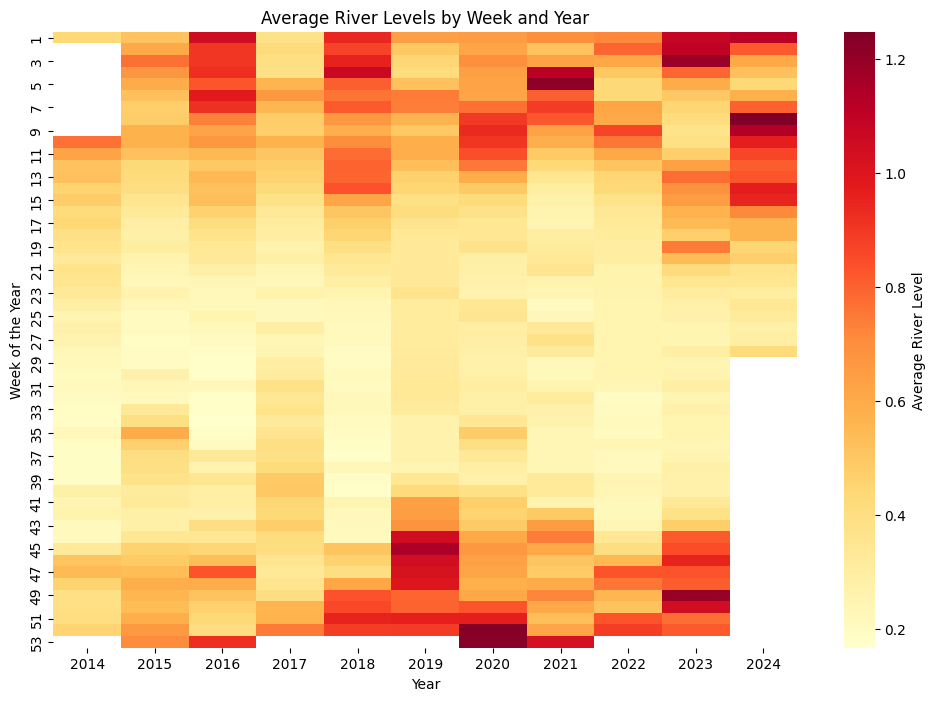

In [34]:
df_weekly = station_1335.groupby(['week', 'year'])['value'].mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(df_weekly, cmap="YlOrRd", cbar_kws={'label': 'Average River Level'})
plt.title('Average River Levels by Week and Year')
plt.xlabel('Year')
plt.ylabel('Week of the Year')
plt.show()


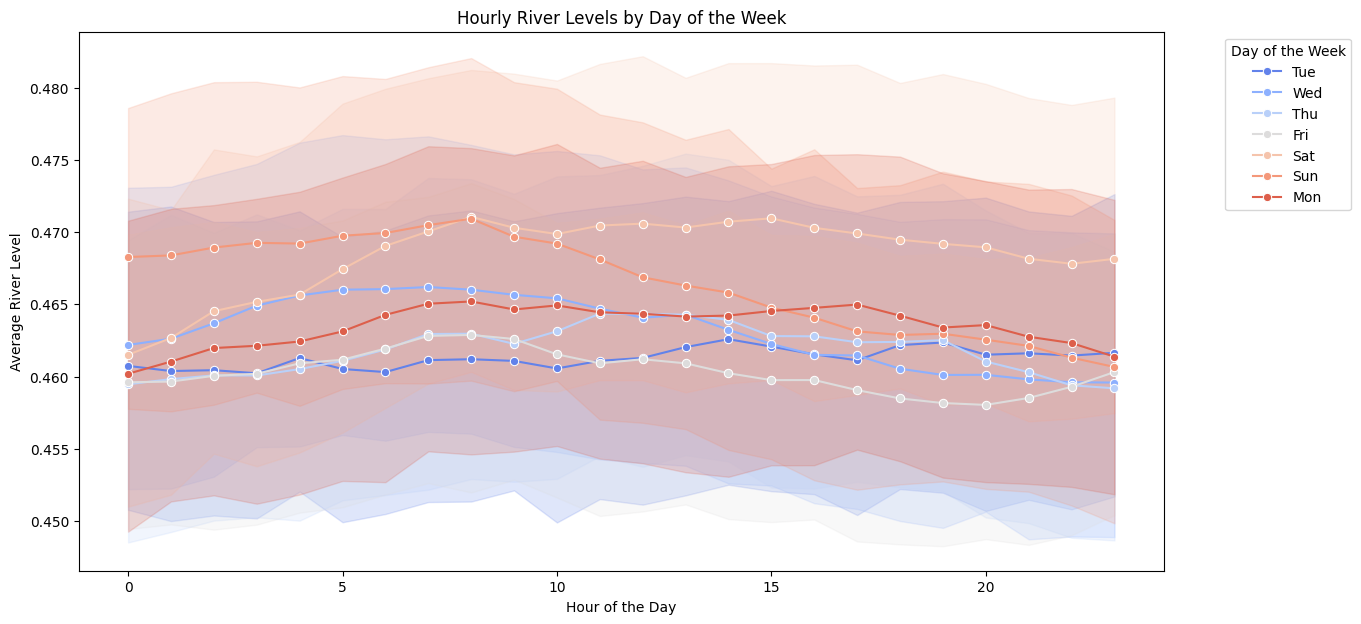

In [35]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=station_1335, x='hour', y='value', hue='day_str', marker='o', palette="coolwarm")
plt.title('Hourly River Levels by Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Average River Level')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



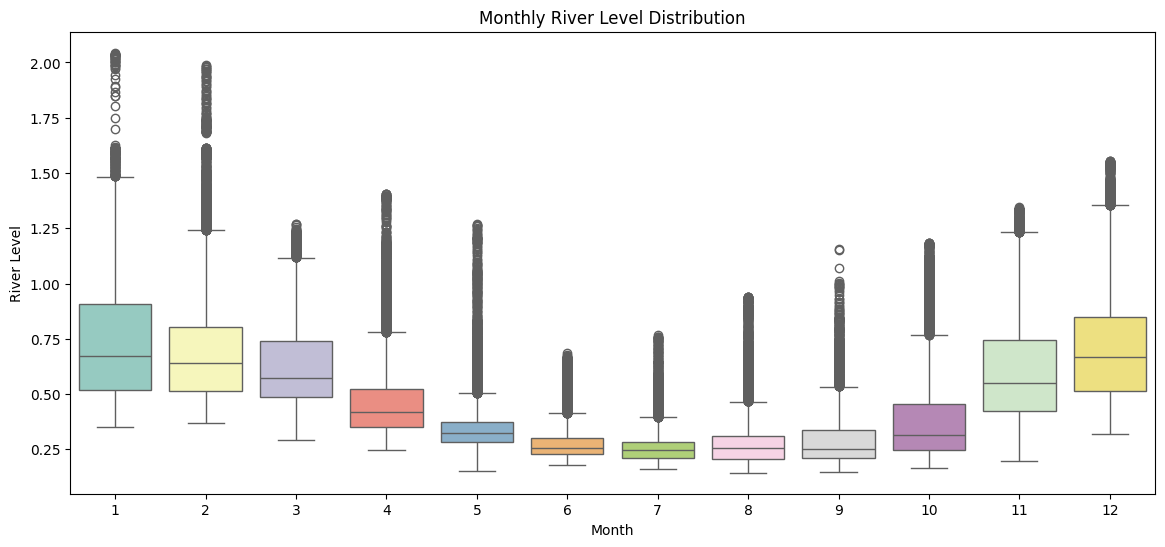


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



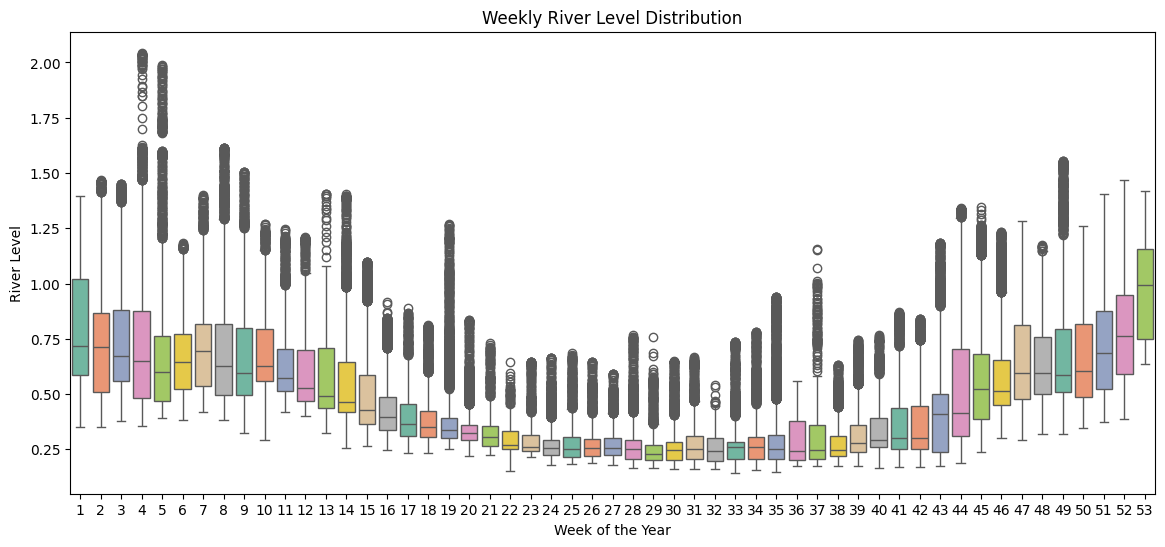

In [37]:
# Box plot by month
plt.figure(figsize=(14, 6))
sns.boxplot(data=station_1335, x='month', y='value', palette="Set3")
plt.title('Monthly River Level Distribution')
plt.xlabel('Month')
plt.ylabel('River Level')
plt.show()

# Box plot by week
plt.figure(figsize=(14, 6))
sns.boxplot(data=station_1335, x='week', y='value', palette="Set2")
plt.title('Weekly River Level Distribution')
plt.xlabel('Week of the Year')
plt.ylabel('River Level')
plt.show()


In [21]:
station_1335['value'].isnull().sum()

np.int64(0)

In [22]:
station_1335.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 363151 entries, 2014-03-04 04:15:00 to 2024-07-11 23:45:00
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   value       363151 non-null  float64
 1   year        363151 non-null  int32  
 2   month       363151 non-null  int32  
 3   week        363151 non-null  UInt32 
 4   hour        363151 non-null  int32  
 5   day         363151 non-null  int32  
 6   day_str     363151 non-null  object 
 7   year_month  363151 non-null  object 
dtypes: UInt32(1), float64(1), int32(4), object(2)
memory usage: 18.4+ MB


In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [64]:
station_1335.isnull().sum()

value    0
dtype: int64

In [24]:
daily_decomposed = seasonal_decompose(station_1335['value'], model='additive', period=96) # daily seasonality? 

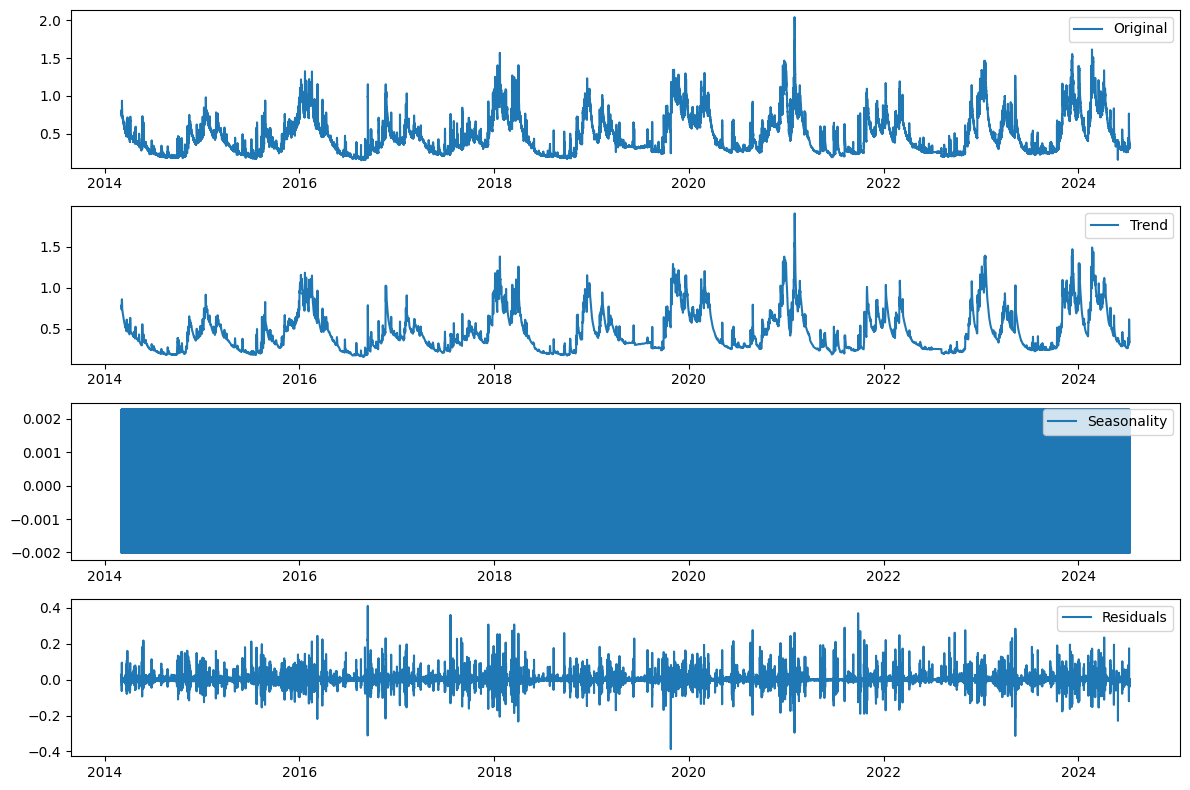

In [25]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(station_1335['value'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(daily_decomposed.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(daily_decomposed.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(daily_decomposed.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [26]:
yearly_decomposed = seasonal_decompose(station_1335['value'], model='additive', period=96 * 365) # yearly seasonality? 

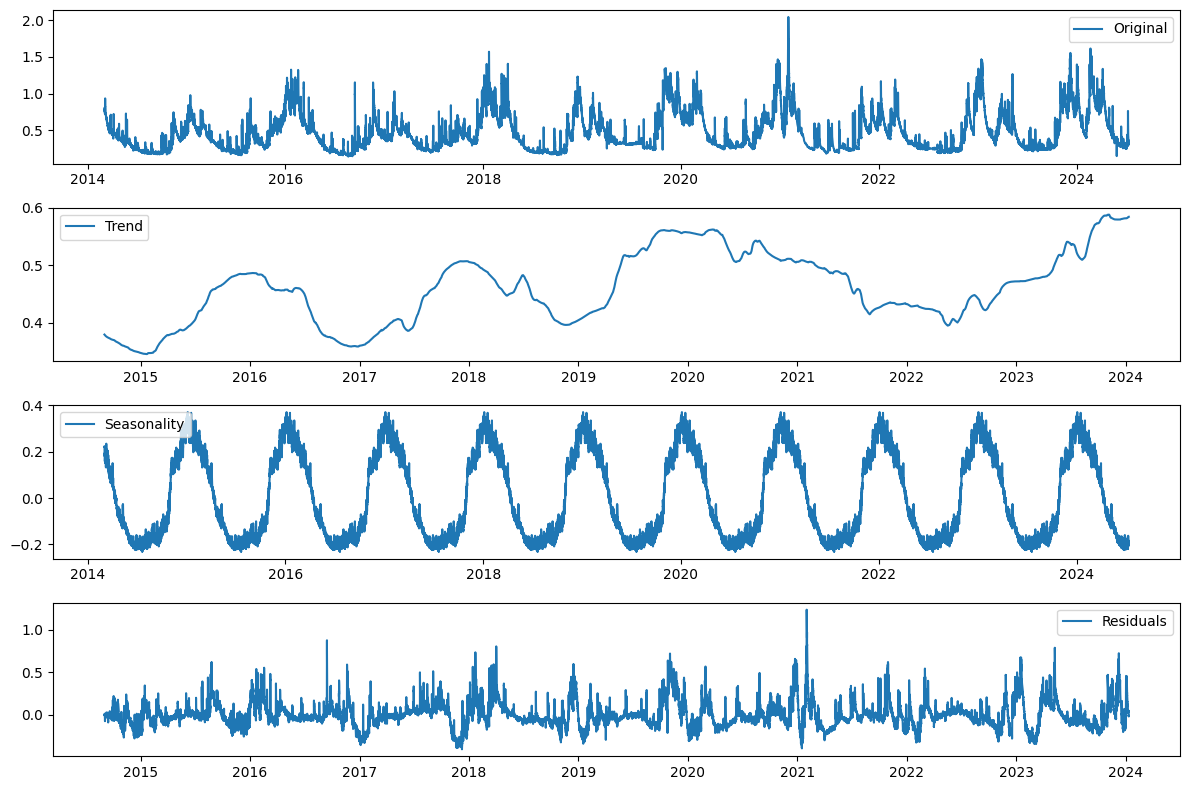

In [27]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(station_1335['value'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(yearly_decomposed.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(yearly_decomposed.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(yearly_decomposed.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [28]:
yearly_mult_decomposed = seasonal_decompose(station_1335['value'], model='multiplicative', period=96 * 365)

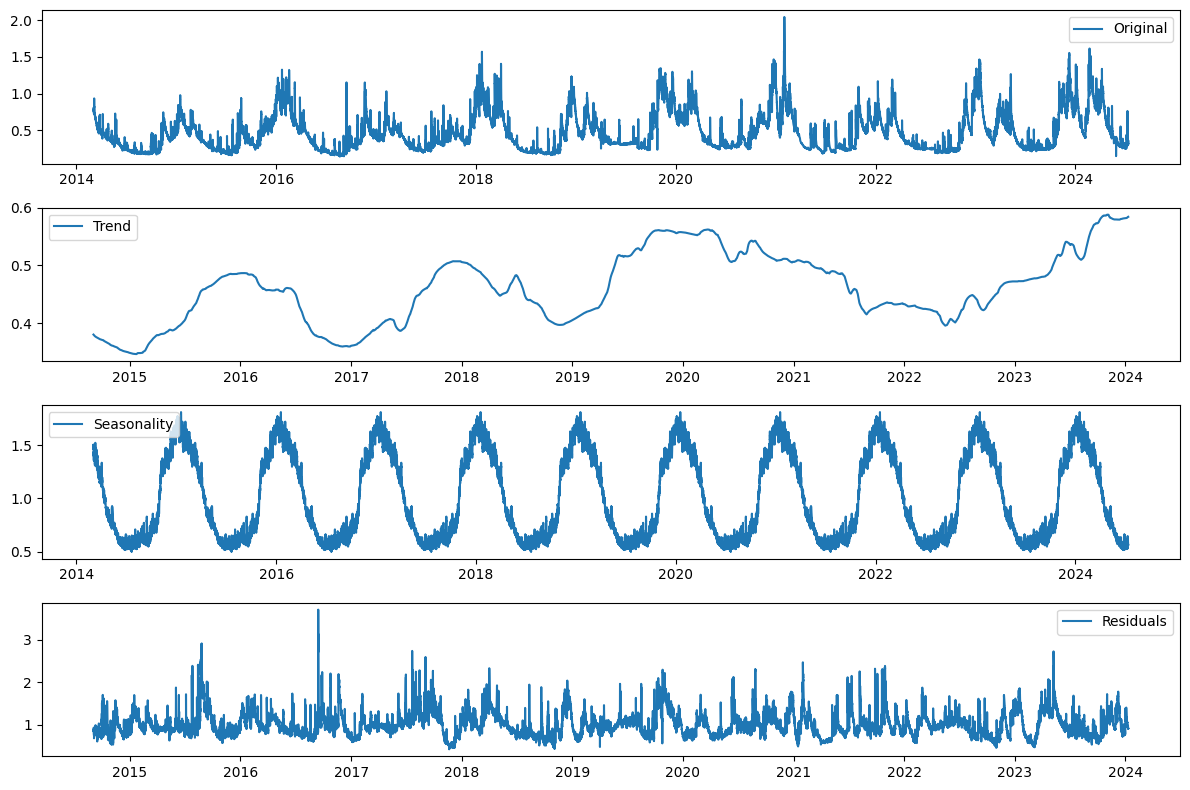

In [29]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(station_1335['value'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(yearly_mult_decomposed.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(yearly_mult_decomposed.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(yearly_mult_decomposed.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()